# Explicabilidade do modelo
Com o modelo já treinado e acertando 92% das vezes em que a reserva é cancelada (em reservas nunca vistas por ele - conjunto de teste), agora nossa tarefa é entender e explicar quais são as decisões que o modelo toma para chegar a determinada classificação.

Usaremos o SHAP (SHapley Additive exPlanations), que é um approach baseado em teoria dos jogos para cumprir essa tarefa. Usaremos a implementação da biblioteca [shap](https://github.com/slundberg/shap) para Python.

Primeiramente, vamos carregar as bibliotecas, nosso modelo e o conjunto de treinamento.

In [3]:
import numpy as np
import pandas as pd
from joblib import load
import shap
import matplotlib.pyplot as plt

#carregando nosso modelo
model = load('xgboost_model.joblib')

#carregando o conjunto de treinamento
X_train = pd.read_csv('X_train.csv')
#y_train = pd.read_csv('y_train.csv')

## Como os valores de SHAP influenciam a previsão do modelo?
Antes de utilizar os valores SHAP na explicação do modelo, vamos entender melhor o que são esses valores. Para cada feature, de cada reserva, é calculado um valor SHAP, conforme vemos no dataframe abaixo.

Incluímos nesse dataframe, também, duas outras colunas. A primeira delas dá a soma dos valores de SHAP de todas as features para cada reserva de hotel. A última coluna mostra qual é a previsão de probabilidade de cancelamento que nosso modelo fez para aquela reserva.

In [18]:
#calculando os valores de SHAP para cada feature de cada reserva
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

#colocando num dataframe os valores de shap para cada feature de reserva
shap_df = pd.DataFrame(shap_values, columns=X_train.columns)

#somando os shap values de todas as features de cada reserva de hotel
shap_sum = np.round(shap_df.sum(axis=1),2)

#fazendo a previsão da probabilidade de cancelamento para cada reserva
predictions_proba = pd.DataFrame(model.predict_proba(X_train), columns=['0', '1']).loc[:, '1']
predictions_proba.name = 'prediction'

In [47]:
#criando dataframe com os shaps, shap_sum e prediction para cada ponto amostral
#observe as duas últimas colunas do df, criadas acima
df = pd.concat([np.round(shap_df,2), pd.Series(shap_sum, name='SHAP_sum'), predictions_proba], axis=1)
df.head(3)

,LeadTime,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,...,ReservedRoomType_G,DepositType_No_Deposit,DepositType_Non_Refund,DepositType_Refundable,CustomerType_Contract,CustomerType_Group,CustomerType_Transient,CustomerType_Transient-Party,SHAP_sum,prediction
0,-0.02,0.37,-0.01,-0.09,-0.05,-0.02,-0.02,-0.0,0.0,-0.08,...,-0.0,-0.25,-0.24,0.0,0.01,-0.0,0.12,0.03,-0.26,0.334418
1,0.23,0.03,0.09,0.04,0.05,0.02,-0.05,-0.0,0.0,-0.06,...,-0.0,-0.30,-0.16,0.0,0.00,-0.0,0.13,0.05,1.75,0.790034
2,0.16,-0.24,-0.02,0.07,-0.01,0.02,-0.01,-0.0,0.0,-0.10,...,-0.0,-0.44,-0.20,0.0,0.00,-0.0,0.07,0.04,-5.08,0.004061


In [4]:
#salvando/carregando o explainer e shap_values
import pickle

#salvando
#pickle.dump(explainer, open("explainer.p", "wb"))
#pickle.dump(shap_values, open("shap_values.p", "wb"))

#carregando
explainer = pickle.load(open("explainer.p", "rb"))
shap_values = pickle.load(open("shap_values.p", "rb"))

Para entender a relação dos valores SHAP com a previsão que nosso modelo fez para certa reserva, plotamos abaixo a soma dos SHAP de todas as features de cada reserva contra a previsão de cancelamento que nosso modelo encontrou para aquela reserva.

Perceba que existe uma relação monotonamente crescente entre essas duas grandezas. Isso significa que quanto maior for o valor total de SHAP para uma reserva, maior é a probabilidade, prevista por nosso modelo, de que essa reserva será cancelada. Em outras palavras, reservas que tem um valor total de SHAP alto também têm alta probabilidade de serem canceladas. E reservas com valor total de SHAP baixo têm baixa probabilidade de serem canceladas. O SHAP de uma certa feature, para uma certa reserva, informa a contribuição marginal que aquela feature tem na previsão da probabilidade de cancelamento.

Por exemplo, para a primeira reserva no dataframe acima, o valor de shap da feature LeadTime é negativo (-0.02). Isso significa que, aos olhos de nosso modelo, o valor de LeadTime (tempo entre o registro da reserva e a data da estadia) observado naquela reserva diminui a probabilidade de que ela seja cancelada. Já a segunda reserva possui um valor de SHAP para o LeadTime de 0.23. Isso significa que, para nosso modelo, o valor de LeadTime observado nessa segunda reserva aumenta a probabilidade de que ela seja cancelada. Como 0.23>0.02, o aumento de probabilidade nesse último caso é mais intenso do que a diminuição de probabilidade observada no primeiro caso.

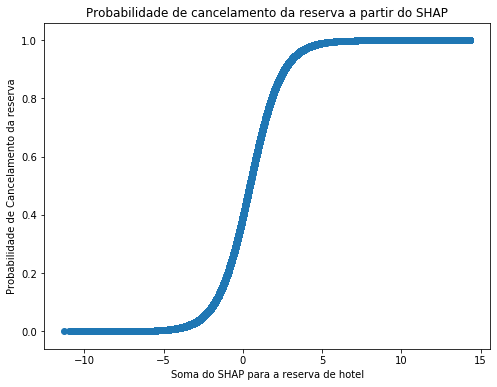

In [82]:
#plot da soma dos valores de shap contra a previsão da probabilidade de cancelamento
f, ax = plt.subplots(figsize=(8, 6))
plt.scatter(shap_sum, predictions_proba)
ax.set(xlabel='Soma do SHAP para a reserva de hotel')
ax.set(ylabel='Probabilidade de Cancelamento da reserva')
ax.set(title='Probabilidade de cancelamento da reserva a partir do SHAP')
plt.show()
#f.savefig("shap_scatter.png", bbox_inches='tight', dpi=400)

## Medindo Feature importances pelo SHAP
Como valores de SHAP altos aumentam a previsão da probabilidade de cancelamento da reserva, e valores de SHAP baixos diminuem essa probabilidade, então a média dos módulos dos valores de SHAP para uma certa feature, ao longo de todo o nosso dataset, dá uma ideia de quão importante aquela feature é para que nosso modelo faça sua previsão.

Essas importâncias relativas são mostradas no gráfico abaixo. Podemos ver que o fato da reserva ter sido feita sem depósito é a feature mais importante para nosso modelo chegar à previsão. Em seguida vem a feature que diz se o cliente é de Portugal. A terceira feature mais importante é a agência que vendeu a reserva. Por fim, temos o número total de pedidos especiais feitos na reserva, e o LeadTime (tempo entre o registro da reserva e a data da estadia).

Apesar das 5 features indicadas acima serem as mais importantes, vemos no gráfico abaixo que as outras features também influenciam de forma significativa o valor de SHAP de uma reserva e, consequentemente, a probabilidade de cancelamento calculada por nosso modelo.

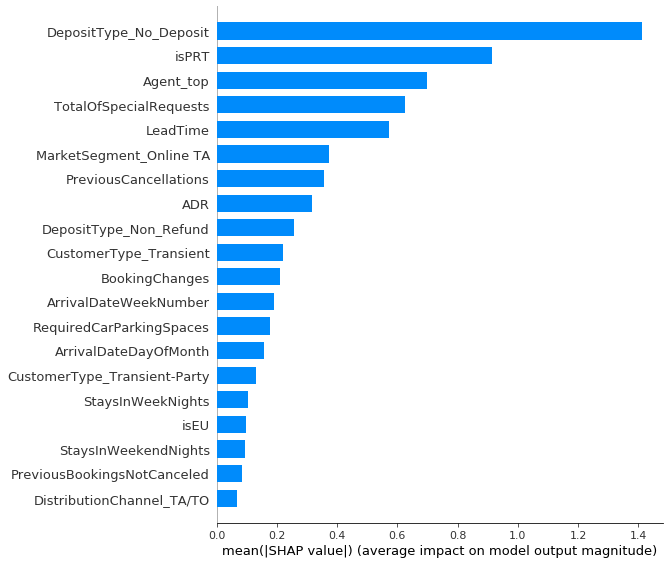

In [5]:
#plotando as feature importances finais
shap.summary_plot(shap_values, X_train.columns, plot_type="bar")

## Impacto das features na previsão do modelo
O gráfico abaixo dá uma visão geral das decisões que nosso modelo faz para chegar à previsão da probabilidade de cancelamento de uma reserva. Cada linha representa uma feature diferente e deve ser lida separadamente. Perceba que as features são ordenadas da mais importante para a menos importante, de acordo com as feature importances mostradas acima.

A primeira linha representa se a reserva foi feita com um depósito (1, em vermelho no gráfico), ou não (0, em azul). Percebemos que quando há um depósito com a reserva, nosso modelo diminui sutilmente a probabilidade de cancelamento. Em contrapartida, quando não houve depósito, a probabilidade de cancelamento aumenta drasticamente. Essa informação pode ser usada pelo hotel no seu business para evitar cancelamentos. Seria interessante estudar, por exemplo, se valeria a pena oferecer um desconto na diária do hotel, ou alguma outra vantagem, para reservas feitas com depósito.

A segunda linha representa se o cliente é de Portugal. Quando o cliente é português, a probabilidade de cancelamento aumenta. Quando não é, a probabilidade diminui.

A terceira linha representa a agência que vendeu a reserva. Podemos observar que existem agências que estão associadas a uma maior probabilidade de cancelamento. Como cada agência é designada por um valor numérico diferente, vamos analisar essa feature mais detalhadamente adiante.

A quarta linha mostra que reservas que não possuem nenhum pedido especial feito têm maior probabilidade de cancelamento. A tendência é que a probabilidade de cancelamento diminua à medida que o número de pedidos especiais aumente.

A quinta linha representa o LeadTime. Observamos que reservas feitas com poucos dias de antecedência têm menor probabilidade de cancelamento do que reservas feitas com muita antecedência.

Vemos também que quando um cliente nunca cancelou uma reserva antes, isso quase não afeta a probabilidade prevista pelo modelo. Mas caso ele já o tenha feito, a probabilidade de cancelamento da reserva aumenta muito.

Ao mesmo tempo, se um cliente não requisitou vaga de estacionamento, a previsão do modelo quase não sofre alteração. Mas no caso da vaga de estacionamento ter sido requisitada, a probabilidade de cancelamento cai drasticamente.

Observamos também que o preço médio da diária não é fator preponderante na probabilidade de cancelamento.

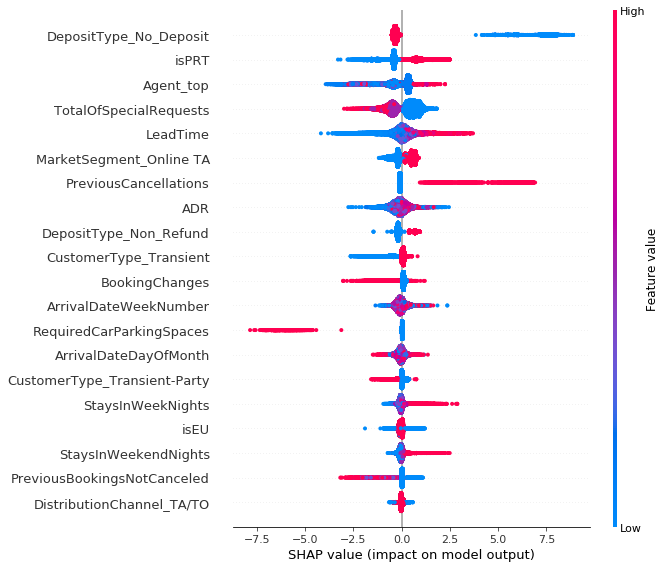

In [6]:
#plotando os valores de SHAP para cada feature de cada reserva
shap.summary_plot(shap_values, X_train)

### O efeito do depósito sobre a previsão do modelo
Confirmamos abaixo que quando há um depósito com a reserva, nosso modelo diminui sutilmente a probabilidade de cancelamento. Em contrapartida, quando não houve depósito, a probabilidade de cancelamento aumenta drasticamente.

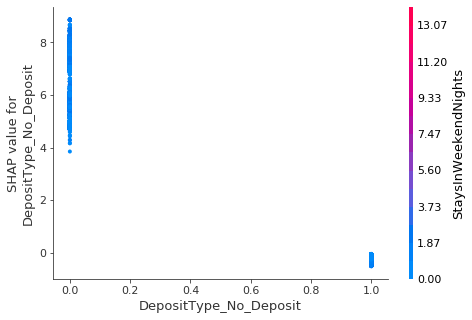

In [7]:
shap.dependence_plot('DepositType_No_Deposit', shap_values, X_train)

### O efeito do cliente ser português sobre a previsão do modelo
Confirmamos abaixo que quando o cliente é português, a probabilidade de cancelamento da reserva tende a aumentar. A novidade é que podemos observar, agora, que existem algumas agências que neutralizam a influência de o cliente ser português sobre a previsão do modelo.

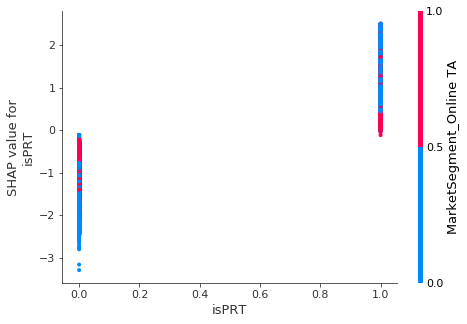

In [8]:
shap.dependence_plot('isPRT', shap_values, X_train)

### O efeito da agência sobre a previsão do modelo
Cada linha vertical no gráfico abaixo corresponde a uma diferente agência de vendas de reservas. Observamos novamente o efeito explicado no gráfico acima.

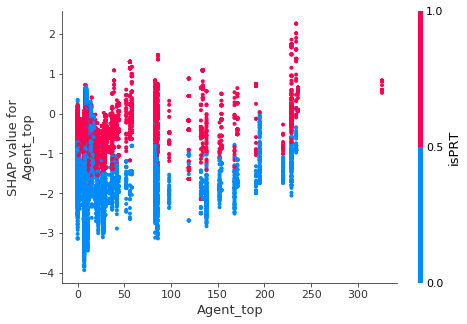

In [9]:
shap.dependence_plot('Agent_top', shap_values, X_train)

### O efeito do numero de pedidos especiais sobre a previsão do modelo
Abaixo, vemos novamente que reservas que não possuem pedidos especiais tendem a ter maior probabilidade de cancelamento. Quando há um ou dois pedidos especiais, essa probabilidade diminui. Quando temos três, quatro ou cinco pedidos especiais, diminui ainda mais.

Vemos também que quando o cliente é de um certo segmento de mercado, Online TA, o efeito acima é reforçado: nenhum pedido especial aumenta mais intesamente a probabilidade de cancelamento, e pelo menos um pedido especial diminui mais intensamente essa probabilidade.

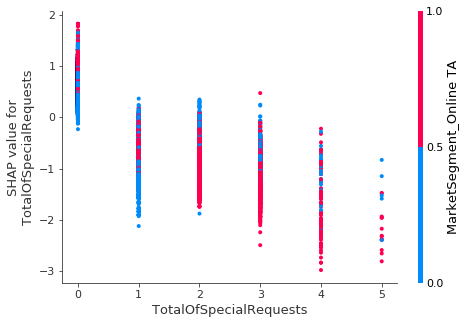

In [10]:
shap.dependence_plot('TotalOfSpecialRequests', shap_values, X_train)

### O efeito do LeadTime sobre a previsão do modelo
Quando temos um lead time de pouquíssimos dias, entre 0 e 5, a probabilidade de cancelamento é drasticamente diminuída. Para lead times maiores, entre 15 e 100 dias, o modelo não altera de forma consistente a previsão de probabilidade. A partir de 100 dias, um aumento no lead time tende a aumentar a previsão da probabilidade de cancelamento.

Esse efeito de diminuição ou aumento da previsão de cancelamento por conta do lead time é intensificado caso o cliente seja do segmento de mercado Online TA, conforme vemos abaixo.

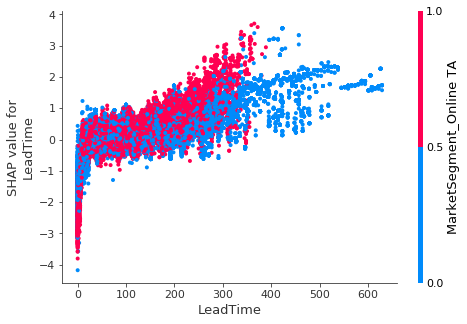

In [11]:
shap.dependence_plot('LeadTime', shap_values, X_train)

### Analisando as decisões do modelo para uma reserva específica
A título de ilustração, vamos analisar as decisões de nosso modelo para chegar na previsão da primeira reserva de nosso conjunto de treinamento.

O gráfico abaixo mostra que o modelo possui um "base value" de 0,3953. Isso significa que se uma reserva tiver cada uma de suas features iguais ao valor médio de cada feature ao longo de todo o conjunto de treinamento, o modelo preveria uma probabilidade de cancelamento de 39.53%.

O modelo vai alterando esse valor base a partir das contribuições marginais de cada feature. Por exemplo, a reserva abaixo tem 1 pedido especial (TotalOfSpecialRequests = 1). Vemos abaixo que a média de pedidos especiais no conjunto de treinamento era de 0,5. Logo, essa reserva possui um número de pedidos especiais acima da média. Soma-se a isso o fato de que o número de pedidos especiais e a previsão do modelo são negativamente correlacionados, como explicado acima. Desse modo, a feature TotalOfSpecialRequests diminui a previsão de probabilidade de cancelamento do modelo. O gráfico mostra que essa diminuição marginal é de aproximadamente 6%.

As features que alteram a previsão para a reserva abaixo de forma mais significativa são Agent_top, ArrivalDateWeekNumber, MarketSegment_Online TA, TotalOfSpecialRequests, isPRT, DepositType_No_Deposit e DepositType_No_Refund. As outras features têm menor impacto na previsão. A contribuição marginal de cada uma para a probabilidade de cancelamento pode ser vista abaixo.

In [21]:
print(f"Média de TotalOfSpecialRequests no conjunto de treinamento: {round(X_train.mean().TotalOfSpecialRequests, 1)}")

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[0], link='logit') # https://github.com/slundberg/shap/issues/29

Média de TotalOfSpecialRequests no conjunto de treinamento: 0.5


#### Só brincando: tentando fitar uma curva no previsão x shap_sum

In [27]:
from scipy.optimize import curve_fit

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

p0 = [max(predictions_proba), np.median(shap_sum),1,min(predictions_proba)] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, shap_sum, predictions_proba,p0, method='dogbox')

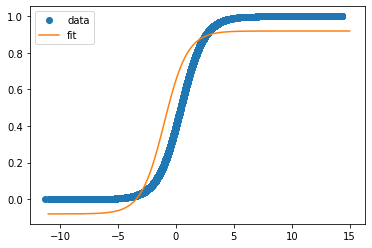

In [35]:
#x = np.linspace(-101, 1050, 1)
x = np.linspace(-11, 15, 1000)
y = sigmoid(x, *popt)


plt.plot(shap_sum, predictions_proba, 'o', label='data')
plt.plot(x,y, label='fit')
#plt.ylim(0, 1.3)
plt.legend(loc='best')

In [83]:
model.predict(X_train).mean()

0.41536543622033933